# Bevezetés a valószínűségszámításba és statisztikába
Ebben a jegyzetfüzetben néhány korábban tárgyalt fogalommal fogunk játszani. A valószínűségszámítás és statisztika számos fogalma jól reprezentált a Python adatfeldolgozó főbb könyvtáraiban, mint például a `numpy` és a `pandas`.


In [117]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

## Véletlen változók és eloszlások
Kezdjük azzal, hogy veszünk egy 30 értékből álló mintát egy 0 és 9 közötti egyenletes eloszlásból. Számítsuk ki az átlagot és a szórást is.


In [118]:
sample = [ random.randint(0,10) for _ in range(30) ]
print(f"Sample: {sample}")
print(f"Mean = {np.mean(sample)}")
print(f"Variance = {np.var(sample)}")

Sample: [0, 8, 1, 0, 7, 4, 3, 3, 6, 7, 1, 0, 6, 3, 1, 5, 9, 2, 4, 2, 5, 6, 8, 7, 1, 9, 8, 2, 3, 7]
Mean = 4.266666666666667
Variance = 8.195555555555556


A mintában található különböző értékek számának vizuális becsléséhez elkészíthetjük a **hisztogramot**:


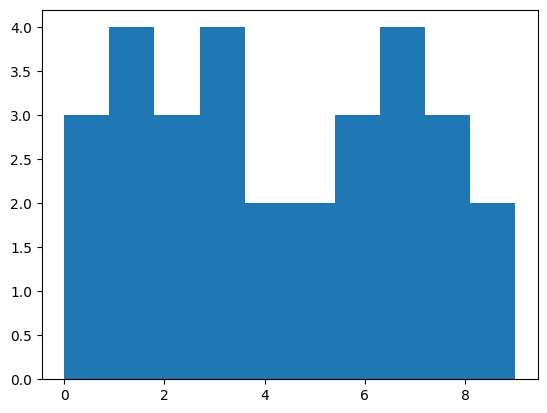

In [119]:
plt.hist(sample)
plt.show()

## Valós adatok elemzése

Az átlag és a szórás nagyon fontos szerepet játszik a valós adatok elemzése során. Töltsük be a baseball játékosokról szóló adatokat innen: [SOCR MLB Height/Weight Data](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_MLB_HeightsWeights)


In [120]:
df = pd.read_csv("../../data/SOCR_MLB.tsv",sep='\t', header=None, names=['Name','Team','Role','Weight','Height','Age'])
df


Empty DataFrame
Columns: [Name, Team, Role, Weight, Height, Age]
Index: []


Egy [**Pandas**](https://pandas.pydata.org/) nevű csomagot használunk itt adatelemzéshez. Később a kurzus során többet fogunk beszélni a Pandas-ról és az adatokkal való munkáról Pythonban.

Számítsuk ki az életkor, magasság és testsúly átlagértékeit:


In [121]:
df[['Age','Height','Weight']].mean()

Age        28.736712
Height    201.726306
Weight     73.697292
dtype: float64

Most koncentráljunk a magasságra, és számítsuk ki a szórást és a varianciát:


In [122]:
print(list(df['Height'])[:20])

[180, 215, 210, 210, 188, 176, 209, 200, 231, 180, 188, 180, 185, 160, 180, 185, 197, 189, 185, 219]


In [123]:
mean = df['Height'].mean()
var = df['Height'].var()
std = df['Height'].std()
print(f"Mean = {mean}\nVariance = {var}\nStandard Deviation = {std}")

Mean = 201.72630560928434
Variance = 441.6355706557866
Standard Deviation = 21.01512718628623


A medián érték és a kvartilisek vizsgálata az átlag mellett is értelmes. Ezeket egy **dobozdiagram** segítségével lehet szemléltetni:


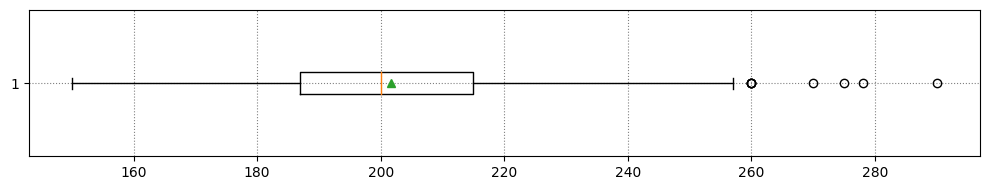

In [124]:
plt.figure(figsize=(10,2))
plt.boxplot(df['Height'], vert=False, showmeans=True)
plt.grid(color='gray', linestyle='dotted')
plt.tight_layout()
plt.show()

Készíthetünk dobozdiagramokat az adathalmazunk részhalmazairól is, például játékos szerepkörök szerint csoportosítva.


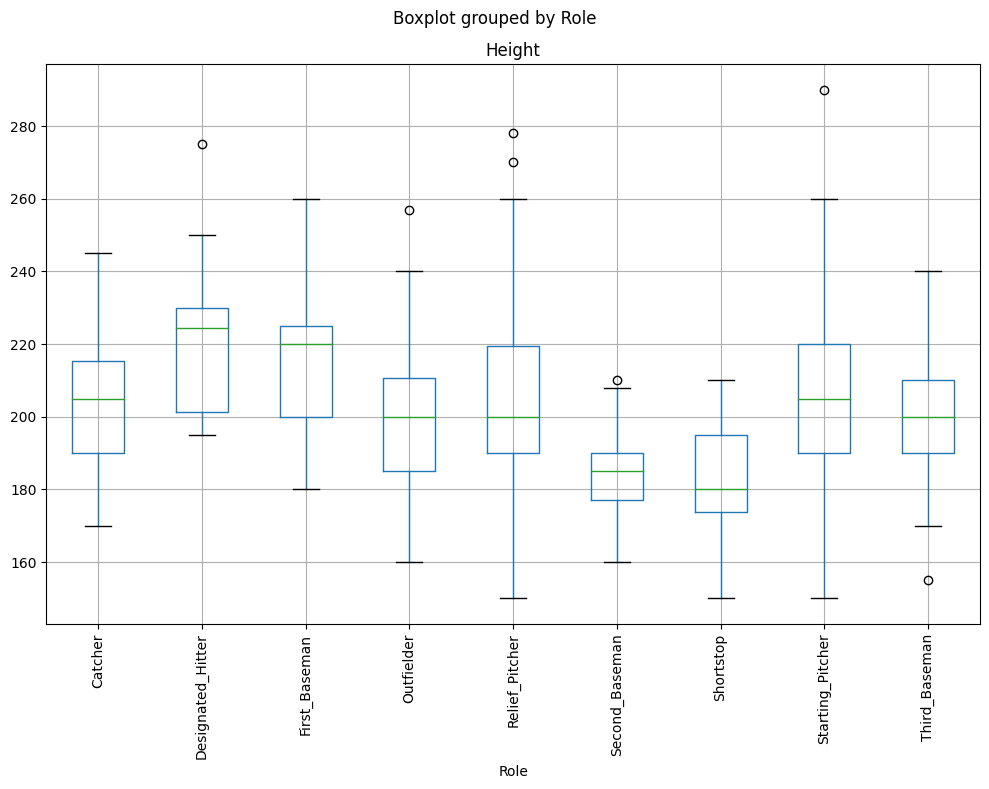

In [125]:
df.boxplot(column='Height', by='Role', figsize=(10,8))
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

> **Megjegyzés**: Ez a diagram azt sugallja, hogy átlagosan az első bázisemberek magassága nagyobb, mint a második bázisembereké. Később megtanuljuk, hogyan tesztelhetjük ezt a hipotézist formálisabban, és hogyan bizonyíthatjuk, hogy adataink statisztikailag szignifikánsak ennek alátámasztására.  

Az életkor, a magasság és a testsúly mind folytonos valószínűségi változók. Mit gondolsz, milyen az eloszlásuk? Egy jó módszer ennek kiderítésére az értékek hisztogramjának megrajzolása:


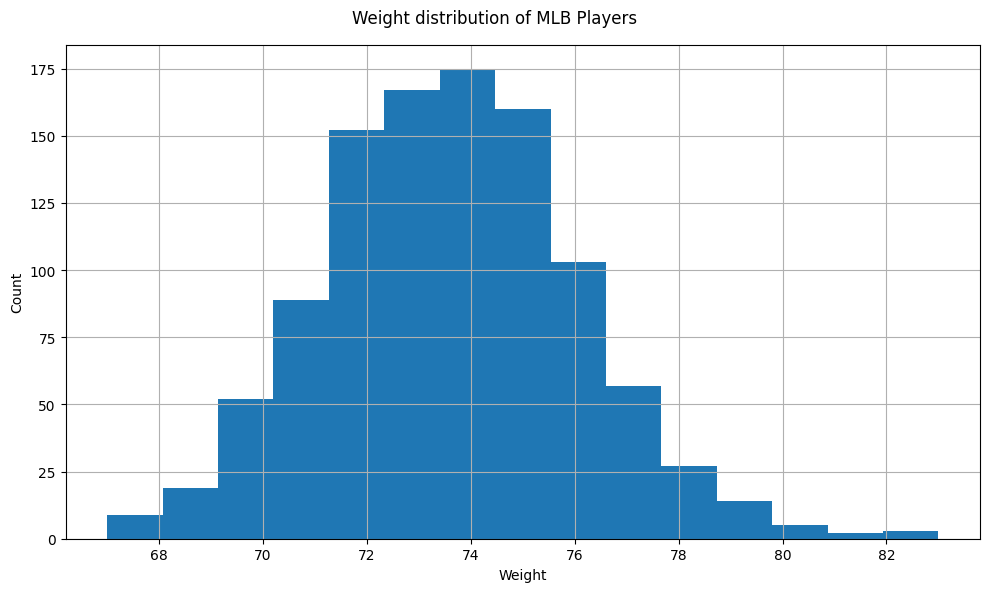

In [126]:
df['Weight'].hist(bins=15, figsize=(10,6))
plt.suptitle('Weight distribution of MLB Players')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Normál eloszlás

Hozzunk létre egy mesterséges mintát súlyokból, amely normál eloszlást követ, ugyanazzal az átlaggal és szórással, mint a valós adataink:


In [127]:
generated = np.random.normal(mean, std, 1000)
generated[:20]

array([183.05261872, 193.52828463, 154.73707302, 204.27140391,
       203.88907247, 213.74665656, 225.10092364, 171.75867917,
       204.3521425 , 207.52870255, 158.53001756, 240.94399197,
       189.9909742 , 180.72442994, 173.4393402 , 175.98883711,
       197.86092769, 188.61598821, 234.19796698, 209.0295457 ])

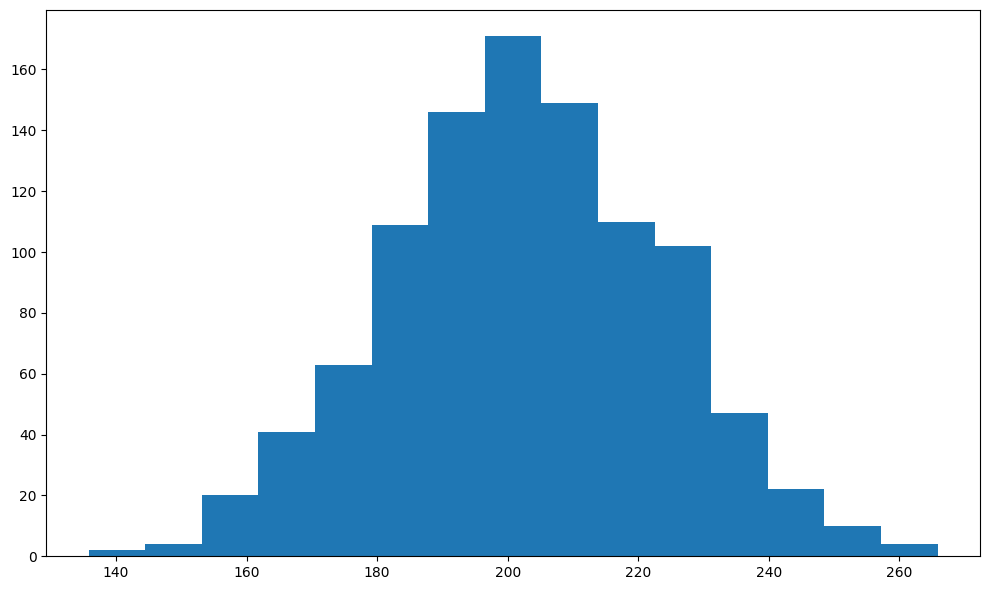

In [128]:
plt.figure(figsize=(10,6))
plt.hist(generated, bins=15)
plt.tight_layout()
plt.show()

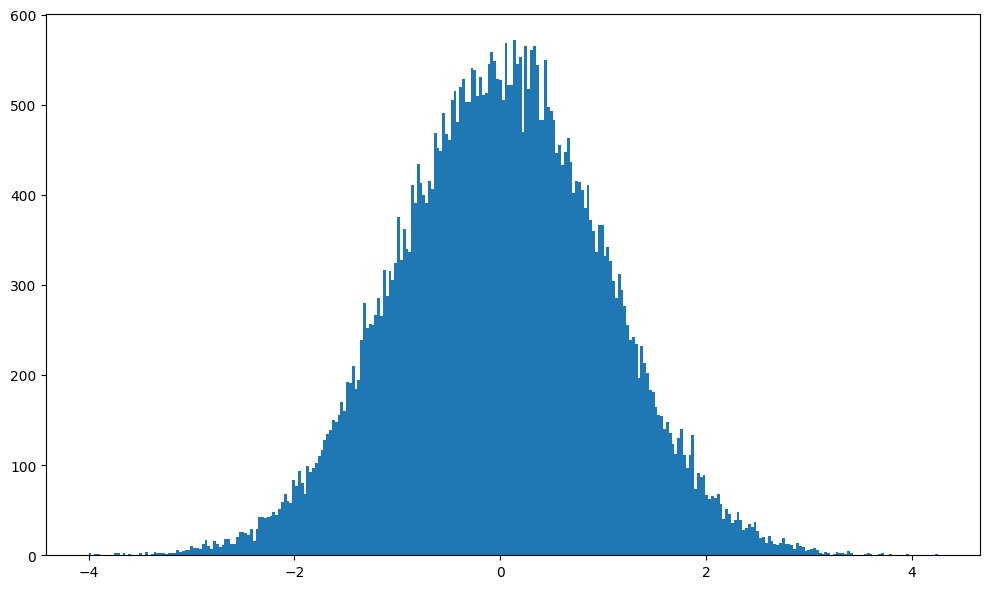

In [129]:
plt.figure(figsize=(10,6))
plt.hist(np.random.normal(0,1,50000), bins=300)
plt.tight_layout()
plt.show()

Mivel a való életben a legtöbb érték normál eloszlású, nem szabad egyenletes eloszlású véletlenszám-generátort használni mintaadatok előállítására. Íme, mi történik, ha egyenletes eloszlással próbálunk súlyokat generálni (amit a `np.random.rand` generál):


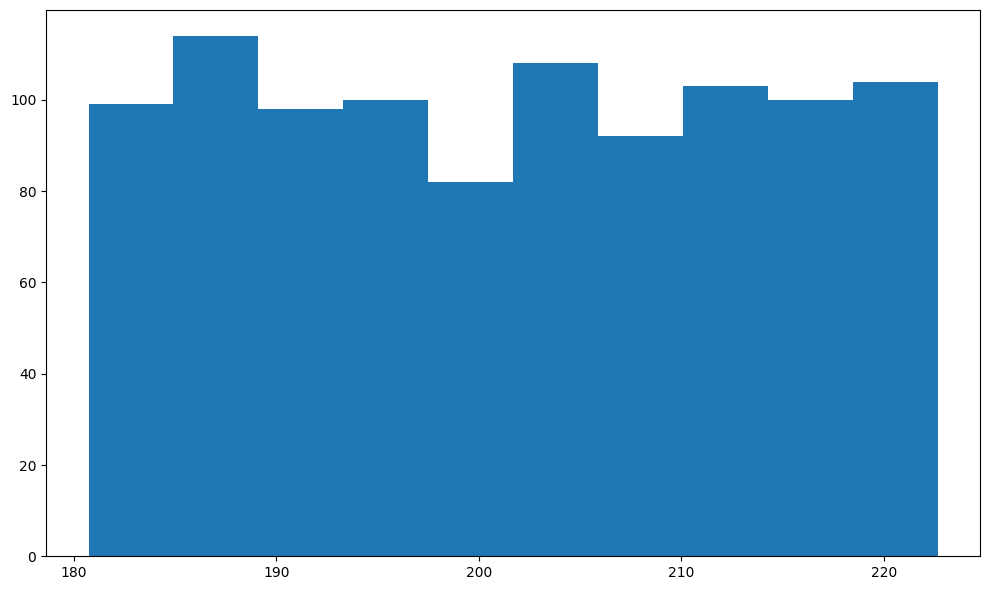

In [130]:
wrong_sample = np.random.rand(1000)*2*std+mean-std
plt.figure(figsize=(10,6))
plt.hist(wrong_sample)
plt.tight_layout()
plt.show()

## Konfidencia-intervallumok

Most számítsuk ki a baseballjátékosok súlyának és magasságának konfidencia-intervallumait. Az alábbi kódot fogjuk használni [ebből a stackoverflow beszélgetésből](https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data):


In [131]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

for p in [0.85, 0.9, 0.95]:
    m, h = mean_confidence_interval(df['Weight'].fillna(method='pad'),p)
    print(f"p={p:.2f}, mean = {m:.2f} ± {h:.2f}")

p=0.85, mean = 73.70 ± 0.10
p=0.90, mean = 73.70 ± 0.12
p=0.95, mean = 73.70 ± 0.14


## Hipotézisvizsgálat

Vizsgáljuk meg a baseball játékosok adatbázisában szereplő különböző szerepeket:


In [132]:
df.groupby('Role').agg({ 'Weight' : 'mean', 'Height' : 'mean', 'Age' : 'count'}).rename(columns={ 'Age' : 'Count'})

Weight      Height  Count
Role                                           
Catcher            72.723684  204.328947     76
Designated_Hitter  74.222222  220.888889     18
First_Baseman      74.000000  213.109091     55
Outfielder         73.010309  199.113402    194
Relief_Pitcher     74.374603  203.517460    315
Second_Baseman     71.362069  184.344828     58
Shortstop          71.903846  182.923077     52
Starting_Pitcher   74.719457  205.321267    221
Third_Baseman      73.044444  200.955556     45

In [133]:
for p in [0.85,0.9,0.95]:
    m1, h1 = mean_confidence_interval(df.loc[df['Role']=='First_Baseman',['Height']],p)
    m2, h2 = mean_confidence_interval(df.loc[df['Role']=='Second_Baseman',['Height']],p)
    print(f'Conf={p:.2f}, 1st basemen height: {m1-h1[0]:.2f}..{m1+h1[0]:.2f}, 2nd basemen height: {m2-h2[0]:.2f}..{m2+h2[0]:.2f}')

Conf=0.85, 1st basemen height: 209.36..216.86, 2nd basemen height: 182.24..186.45
Conf=0.90, 1st basemen height: 208.82..217.40, 2nd basemen height: 181.93..186.76
Conf=0.95, 1st basemen height: 207.97..218.25, 2nd basemen height: 181.45..187.24


Láthatjuk, hogy az intervallumok nem fedik át egymást.

Egy statisztikailag helyesebb módja a hipotézis bizonyításának a **Student t-teszt** alkalmazása:


In [134]:
from scipy.stats import ttest_ind

tval, pval = ttest_ind(df.loc[df['Role']=='First_Baseman',['Height']], df.loc[df['Role']=='Second_Baseman',['Height']],equal_var=False)
print(f"T-value = {tval[0]:.2f}\nP-value: {pval[0]}")

T-value = 9.77
P-value: 1.4185554184322326e-15


A `ttest_ind` függvény által visszaadott két érték a következők:  
* A p-érték annak a valószínűségét jelzi, hogy a két eloszlásnak azonos az átlaga. Esetünkben ez nagyon alacsony, ami erős bizonyítékot szolgáltat arra, hogy az első bázisemberek magasabbak.  
* A t-érték a normalizált átlagkülönbség köztes értéke, amelyet a t-teszt során használnak, és egy adott megbízhatósági szinthez tartozó küszöbértékkel vetik össze.  


## Normális eloszlás szimulálása a központi határeloszlás tétellel

A Pythonban található pszeudo-véletlenszám-generátor úgy van kialakítva, hogy egyenletes eloszlást adjon. Ha normális eloszlású generátort szeretnénk létrehozni, használhatjuk a központi határeloszlás tételt. Ahhoz, hogy normális eloszlású értéket kapjunk, egyszerűen kiszámítjuk egy egyenletesen generált minta átlagát.


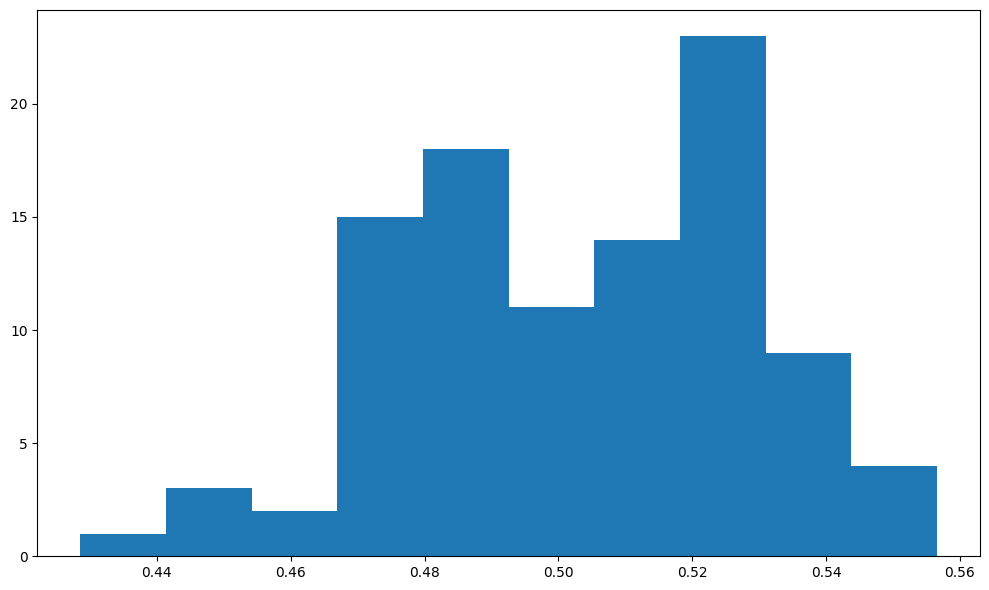

In [135]:
def normal_random(sample_size=100):
    sample = [random.uniform(0,1) for _ in range(sample_size) ]
    return sum(sample)/sample_size

sample = [normal_random() for _ in range(100)]
plt.figure(figsize=(10,6))
plt.hist(sample)
plt.tight_layout()
plt.show()

## Korreláció és a Gonosz Baseball Vállalat

A korreláció lehetővé teszi, hogy kapcsolatokat találjunk adat-sorozatok között. Példánkban tegyük fel, hogy létezik egy gonosz baseball vállalat, amely a játékosait a magasságuk alapján fizeti - minél magasabb a játékos, annál több pénzt kap. Tegyük fel, hogy van egy alapfizetés, ami $1000, és egy további bónusz $0 és $100 között, a magasságtól függően. Vegyük az MLB valódi játékosait, és számítsuk ki az elképzelt fizetésüket:


In [136]:
heights = df['Height']
salaries = 1000+(heights-heights.min())/(heights.max()-heights.mean())*100
print(list(zip(heights, salaries))[:10])

[(180, 1033.985209531635), (215, 1073.6346206518763), (210, 1067.9704190632704), (210, 1067.9704190632704), (188, 1043.0479320734046), (176, 1029.4538482607504), (209, 1066.837578745549), (200, 1056.6420158860585), (231, 1091.760065735415), (180, 1033.985209531635)]


Számítsuk ki most ezeknek a sorozatoknak a kovarianciáját és korrelációját. Az `np.cov` egy úgynevezett **kovariancia mátrixot** ad nekünk, amely a kovariancia kiterjesztése több változóra. A kovariancia mátrix $M$ eleme $M_{ij}$ az input változók $X_i$ és $X_j$ közötti korrelációt jelenti, míg a diagonális értékek $M_{ii}$ az $X_{i}$ varianciáját adják. Hasonlóképpen, az `np.corrcoef` a **korrelációs mátrixot** adja meg.


In [137]:
print(f"Covariance matrix:\n{np.cov(heights, salaries)}")
print(f"Covariance = {np.cov(heights, salaries)[0,1]}")
print(f"Correlation = {np.corrcoef(heights, salaries)[0,1]}")

Covariance matrix:
[[441.63557066 500.30258018]
 [500.30258018 566.76293389]]
Covariance = 500.3025801786725
Correlation = 0.9999999999999997


A korreláció, amely egyenlő 1-gyel, azt jelenti, hogy erős **lineáris kapcsolat** van két változó között. A lineáris kapcsolatot vizuálisan láthatjuk, ha az egyik értéket a másik ellenében ábrázoljuk:


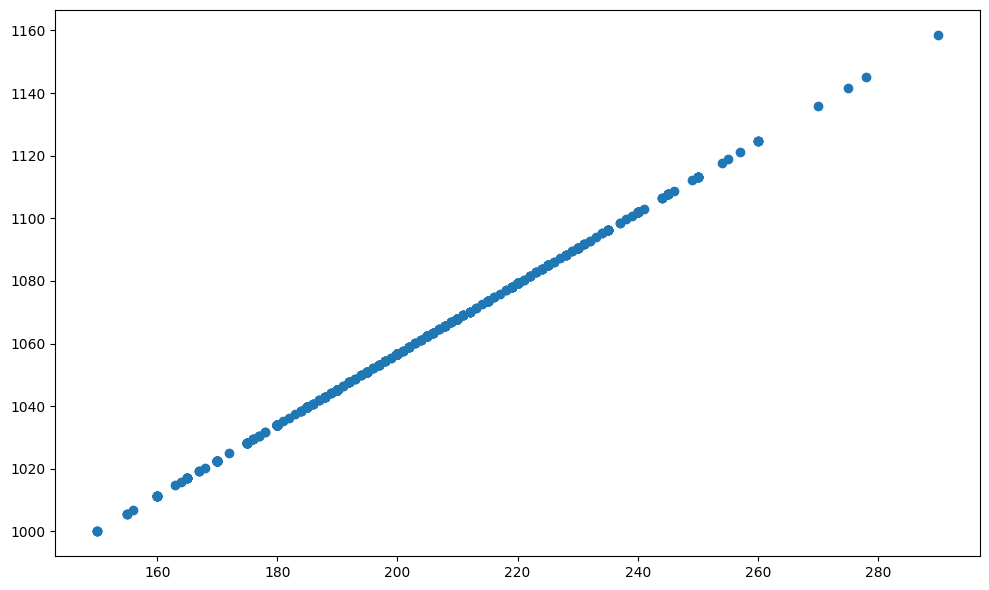

In [138]:
plt.figure(figsize=(10,6))
plt.scatter(heights,salaries)
plt.tight_layout()
plt.show()

Nézzük meg, mi történik, ha a kapcsolat nem lineáris. Tegyük fel, hogy vállalatunk úgy döntött, hogy elrejti a magasságok és fizetések közötti nyilvánvaló lineáris összefüggést, és valamilyen nemlinearitást vezetett be a képletbe, például a `sin` függvényt:


In [139]:
salaries = 1000+np.sin((heights-heights.min())/(heights.max()-heights.mean()))*100
print(f"Correlation = {np.corrcoef(heights, salaries)[0,1]}")

Correlation = 0.9910655775558532


Ebben az esetben a korreláció kissé kisebb, de még mindig elég magas. Most, hogy a kapcsolat még kevésbé legyen nyilvánvaló, érdemes lehet némi extra véletlenszerűséget hozzáadni azáltal, hogy egy véletlen változót adunk a fizetéshez. Nézzük meg, mi történik:


In [140]:
salaries = 1000+np.sin((heights-heights.min())/(heights.max()-heights.mean()))*100+np.random.random(size=len(heights))*20-10
print(f"Correlation = {np.corrcoef(heights, salaries)[0,1]}")

Correlation = 0.948230287835537


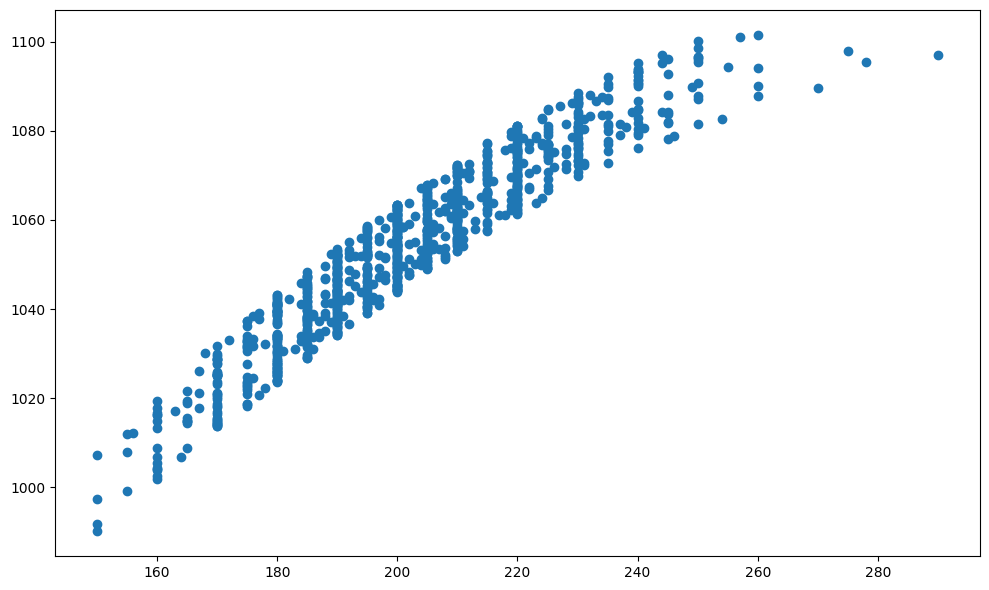

In [141]:
plt.figure(figsize=(10,6))
plt.scatter(heights, salaries)
plt.tight_layout()
plt.show()

> Tudod, miért rendeződnek a pontok ilyen függőleges vonalakba?

Megfigyeltük az összefüggést egy mesterségesen létrehozott fogalom, mint például a fizetés, és a megfigyelt változó, *magasság* között. Nézzük meg, hogy a két megfigyelt változó, mint például a magasság és a súly, is mutat-e összefüggést:


In [142]:
np.corrcoef(df['Height'],df['Weight'])

array([[1.        , 0.52959196],
       [0.52959196, 1.        ]])

Sajnos nem kaptunk semmilyen eredményt - csak néhány furcsa `nan` értéket. Ennek az az oka, hogy a sorozatunkban néhány érték nincs meghatározva, és `nan`-ként van jelölve, ami miatt a művelet eredménye is meghatározatlan lesz. Ha megnézzük a mátrixot, láthatjuk, hogy a `Weight` az a problémás oszlop, mivel a `Height` értékek közötti önkorrelációt számítottuk ki.

> Ez a példa jól mutatja a **adatelőkészítés** és **adat-tisztítás** fontosságát. Megfelelő adatok nélkül semmit sem tudunk kiszámítani.

Használjuk a `fillna` metódust a hiányzó értékek kitöltésére, majd számítsuk ki a korrelációt:


In [143]:
np.corrcoef(df['Height'],df['Weight'].fillna(method='pad'))

array([[1.        , 0.52959196],
       [0.52959196, 1.        ]])

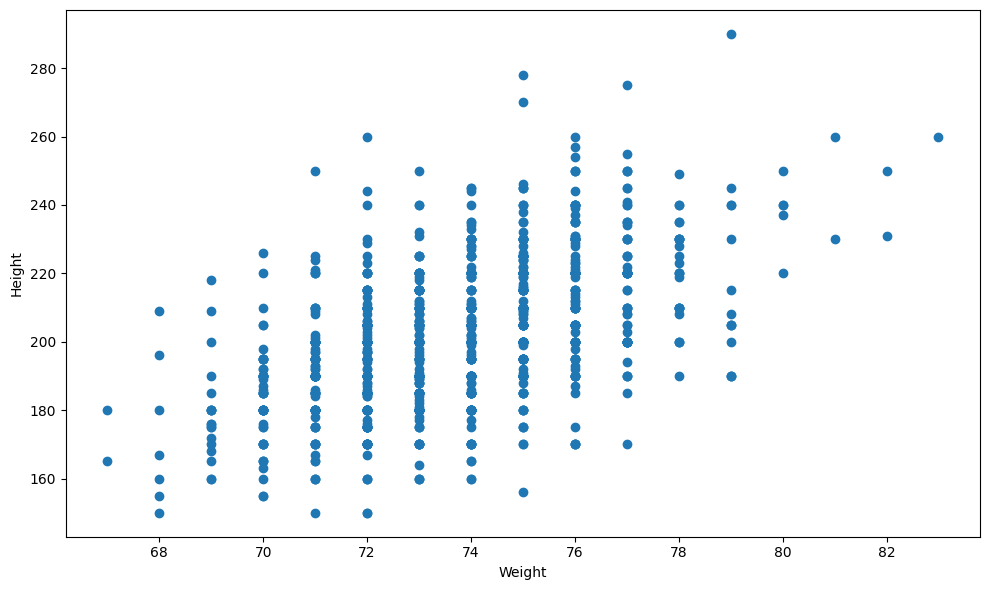

In [144]:
plt.figure(figsize=(10,6))
plt.scatter(df['Weight'],df['Height'])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

## Következtetés

Ebben a jegyzetfüzetben megtanultuk, hogyan végezzünk alapvető műveleteket az adatokon statisztikai függvények kiszámításához. Most már tudjuk, hogyan használjunk egy megbízható matematikai és statisztikai eszköztárat bizonyos hipotézisek igazolására, valamint hogyan számítsunk konfidencia-intervallumokat tetszőleges változókra egy adott adatminta alapján.



---

**Felelősségkizárás**:  
Ez a dokumentum az [Co-op Translator](https://github.com/Azure/co-op-translator) AI fordítási szolgáltatás segítségével készült. Bár törekszünk a pontosságra, kérjük, vegye figyelembe, hogy az automatikus fordítások hibákat vagy pontatlanságokat tartalmazhatnak. Az eredeti dokumentum az eredeti nyelvén tekintendő hiteles forrásnak. Kritikus információk esetén javasolt a professzionális, emberi fordítás igénybevétele. Nem vállalunk felelősséget a fordítás használatából eredő félreértésekért vagy téves értelmezésekért.
